In [1]:
import yfinance as yf
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import math
import matplotlib.pyplot as plt
import warnings
from ipywidgets import IntProgress, FloatProgress
from IPython.display import display

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 150)


In [2]:
# Parameters
LST_B3_STOCKS = ["ABEV3","ALPA4","ALSO3","ARZZ3","ASAI3","AURE3","AZUL4","B3SA3","BBAS3","BBDC3","BBDC4","BBSE3","BEEF3","BPAC11","BRAP4","BRFS3","BRKM5","CASH3","CBAV3","CCRO3","CIEL3","CMIG4","CMIN3","COGN3","CPFE3","CPLE6","CRFB3","CSAN3","CSMG3","CSNA3","CVCB3","CYRE3","DIRR3","DXCO3","ECOR3","EGIE3","ELET3","ELET6","EMBR3","ENEV3","ENGI11","EQTL3","EZTC3","FLRY3","GGBR4","GMAT3","GOAU4","GOLL4","HAPV3","HYPE3","IGTI11","IRBR3","ITSA4","ITUB4","JBSS3","KLBN11","LREN3","LWSA3","MDIA3","MGLU3","MOVI3","MRFG3","MRVE3","MULT3","NTCO3","PCAR3","PETR3","PETR4","PETZ3","PRIO3","PSSA3","QUAL3","RADL3","RAIL3","RAIZ4","RDOR3","RECV3","RENT3","RRRP3","SANB11","SBSP3","SIMH3","SLCE3","SMTO3","SOMA3","STBP3","SUZB3","TAEE11","TIMS3","TOTS3","TRPL4","UGPA3","USIM5","VALE3","VAMO3","VBBR3","VIVA3","VIVT3","WEGE3","YDUQ3"]
PATH_LS_DATA = 'ls_data/'

In [3]:
def extractYahooData(lst_stock_tickers, start_date = "2018-01-01", end_date = None):
    if end_date == None:
        end_date = pd.to_datetime('today').normalize()
    else:
        end_date = pd.to_datetime(end_date).normalize()

    lst_assets=[]
    for ticker in lst_stock_tickers:
        # try exceptiom: se der ruim, pula a iteração
        df_stock = yf.download(ticker+'.SA', start = start_date, end = end_date)
        print(ticker)
        if len(df_stock) != 0:
            df_stock = df_stock[["Adj Close"]]
            df_stock.loc[:, "ticker"] = ticker
            lst_assets.append(df_stock)


    return pd.concat(lst_assets)

def transformYahooData(df):
    # Reseting index to pivoting
    df.reset_index(inplace = True)
    
    # Pivoting Data
    df = df.pivot(index = "Date", columns = "ticker", values = "Adj Close")
    
    # Renaming index
    df.index.names = ['date']

    # Fill NA
    df = df.fillna(method='ffill')

    return df

def loadYahooData(df, path_ls_data):
    df.to_csv(path_ls_data+'yahoo_stock_data.csv')
    return None

def etlyahoo(lst_stock_tickers, path_ls_data, start_date = "2018-01-01", end_date = None):
    df = extractYahooData(lst_stock_tickers, start_date, end_date)
    df = transformYahooData(df)
    loadYahooData(df, path_ls_data)
    
    return None

def updateYahooData(path_ls_data, lst_stock_tickers):
    df_old = pd.read_csv(path_ls_data+'yahoo_stock_data.csv')
    max_date = pd.to_datetime(df_old['date'].max()).normalize()
    start_date = max_date + pd.DateOffset(days=1)
    end_date = pd.to_datetime('today').normalize()

    df_new = extractYahooData(lst_stock_tickers, start_date, end_date)
    df_new = transformYahooData(df_new)
    df_new.reset_index(inplace = True)
    df_new = pd.concat([df_old, df_new])
    df_new.set_index('date', inplace = True)

    return loadYahooData(df_new, path_ls_data)

def get_data(path_ls_data, max_date = None):
    if max_date == None:
        return pd.read_csv(path_ls_data+'yahoo_stock_data.csv', index_col = 'date').reset_index()
    else:
        return pd.read_csv(path_ls_data+'yahoo_stock_data.csv', index_col = 'date').loc[:max_date].reset_index()
        
def getPairs(df):
    assets = list(df.columns)
    assets.remove('date')
    
    lst_pairs = []
    for first in assets:
        for second in assets:
            if first != second:
                lst_pairs.append(first+'/'+second)
                
    return lst_pairs

def getPairsResiduals(lst_pairs, df_stocks, col_name_date = 'date', periods = 252):
    df_residuals = pd.DataFrame()
    df_residuals[col_name_date] = df_stocks[col_name_date].sort_values(ascending = False)[:periods]
    
    pairs_column = []
    p_values = []
    adf_column = []
    beta_column = []
    desv_column = []
    halflife_column = []
    
    progress_bar = IntProgress(min=0, max=len(lst_pairs))
    display(progress_bar)
    for i, pair in enumerate(lst_pairs):
        progress_bar.value = i+1
        
        asset1 = pair.split('/')[0]
        asset2 = pair.split('/')[1]
        
        df_res = df_stocks[[col_name_date, asset1, asset2]].sort_values(by=col_name_date, ascending = False)[:periods]
        
        X = df_res.iloc[:, 1].values.reshape(-1, 1)
        Y = df_res.iloc[:, 2].values.reshape(-1, 1)

        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        
        Y_pred = linear_regressor.predict(X)
        df_res['residual'] = Y_pred - Y
        
        df_residuals[pair] = df_res['residual']
        
        mean = df_res['residual'].mean()
        std = df_res['residual'].std()
        
        adf = adfuller(df_res['residual'])
        adf_column.append(adf[0])
        p_values.append((1-adf[1])*100)
        pairs_column.append(pair) 
        beta_column.append(linear_regressor.coef_[0])
        desv_column.append(abs((df_res['residual'].iloc[0] - mean)/std))
        halflife_column.append(math.log(2)/linear_regressor.coef_[0])
    
    dict_stats = {'pair':pairs_column,
                  'adf':adf_column,
                  'beta':beta_column,
                  'desv':desv_column,
                  'halflife':halflife_column,
                  'p_value':p_values
                 }
    
    df_stats = pd.DataFrame(dict_stats)
    
    return df_residuals, df_stats

def double_cointegration(df, check = False):
    if check == True:
        lst_pairs = list(df.pair)
        double_cointegration_pairs = []
        for pair in lst_pairs:
            inverted_pair = pair.split('/')[1]+'/'+pair.split('/')[0]
            if inverted_pair in lst_pairs:
                double_cointegration_pairs.append(pair)
        return df[df["pair"].isin(double_cointegration_pairs)]
    else:
        return df

## ELT Process

In [ ]:
#etlyahoo(LST_B3_STOCKS, PATH_LS_DATA)
updateYahooData(PATH_LS_DATA, LST_B3_STOCKS)

## L&S Screaning

In [85]:
# Get stock data
df_stocks = get_data(PATH_LS_DATA, max_date = "2024-01-31")

# Get pairs
list_pairs = getPairs(df_stocks)

# Calculate Residuals between pairs
prds = [160, 200, 252]
df_pairs_res, df_pairs_stats = getPairsResiduals(list_pairs, df_stocks, col_name_date = 'date', periods = prds[2])

IntProgress(value=0, max=9702)

- 1% -4,32%
- 5% -3,78%
- 10% -3,50%

Para cada 1 real do ativo 1, operar beta*reais do ativo 2

In [86]:
df_screaning = df_pairs_stats[
    (df_pairs_stats['adf'] <= -4.32) & 
    (df_pairs_stats['desv'] >= 1.85) & 
    (df_pairs_stats['desv'] < 3) & 
    (df_pairs_stats['beta'] >= 0.5) & 
    (df_pairs_stats['beta'] < 2) & 
    (df_pairs_stats['halflife'] <= 999)].sort_values(by='desv', ascending=False)

df_screaning = double_cointegration(df_screaning, check = True)

df_screaning.reset_index(drop=True)

,pair,adf,beta,desv,halflife,p_value
0,BBDC4/IGTI11,-4.767798,[1.206416333057729],2.592883,[0.5745505606701505],99.993735
1,BBDC3/IGTI11,-4.616499,[1.3807499712450828],2.517178,[0.502007745786809],99.987958
2,IGTI11/BBDC4,-4.620405,[0.710213170208445],2.175765,[0.975970609439007],99.988157
3,IGTI11/BBDC3,-4.398080,[0.6358622455505882],2.116059,[1.090090165614023],99.970084


BBDC4/IGTI11
Beta:  1.206416333057729
Desv:  2.5928828699344804
Halflife:  0.5745505606701505


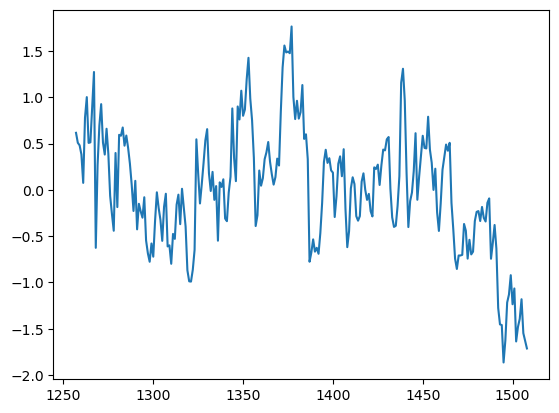

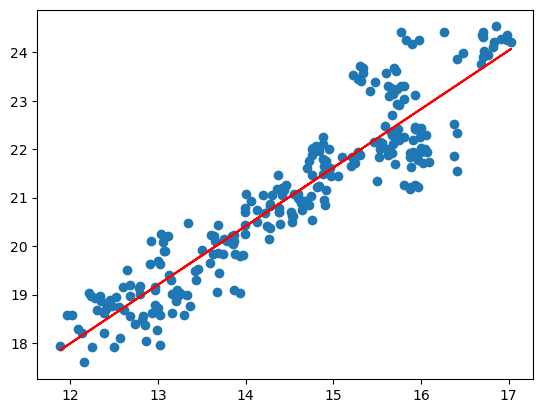

BBDC3/IGTI11
Beta:  1.3807499712450828
Desv:  2.51717792648999
Halflife:  0.502007745786809


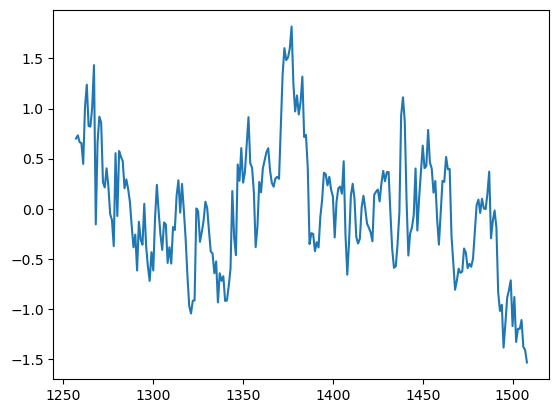

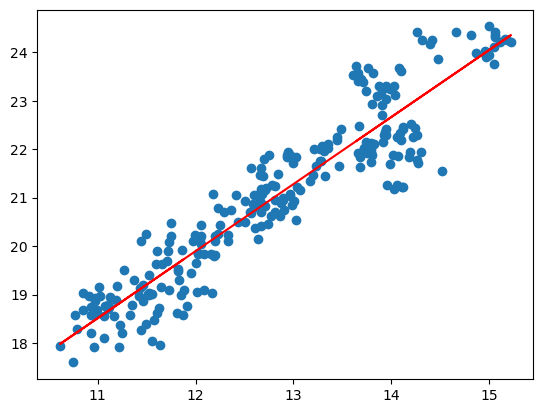

IGTI11/BBDC4
Beta:  0.710213170208445
Desv:  2.1757654156675033
Halflife:  0.975970609439007


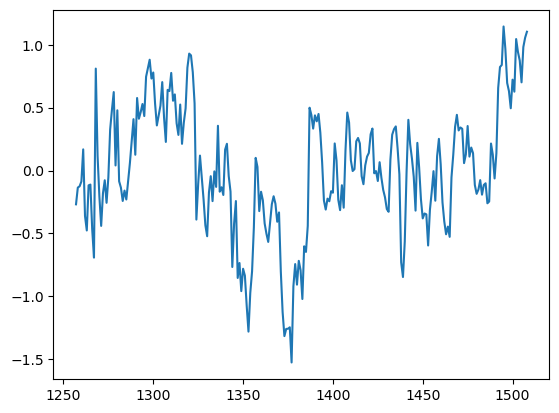

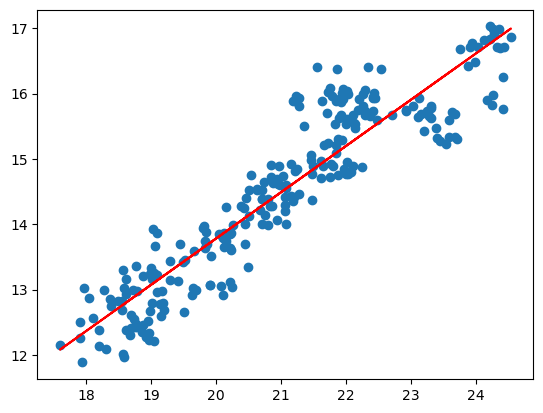

IGTI11/BBDC3
Beta:  0.6358622455505882
Desv:  2.11605949892874
Halflife:  1.090090165614023


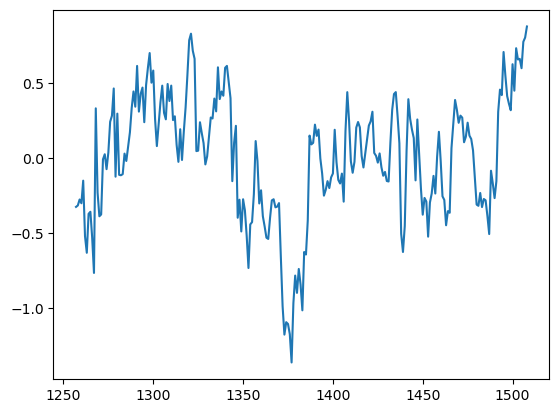

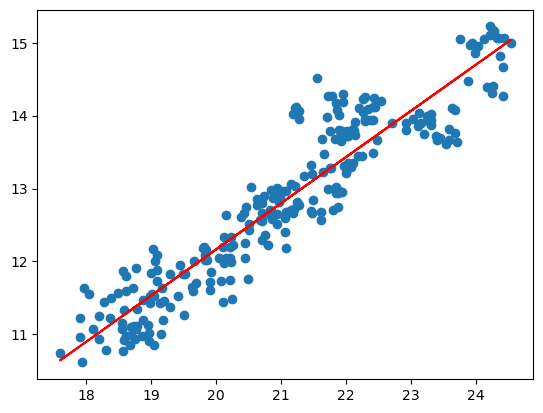

In [87]:
for n_pair in range(len(df_screaning)):

    print(df_screaning.iloc[n_pair,0])
    print("Beta: ", df_screaning.iloc[n_pair,2][0])
    print("Desv: ", df_screaning.iloc[n_pair,3])
    print("Halflife: ", df_screaning.iloc[n_pair,4][0])

    # Residual
    pair1 = df_screaning.iloc[n_pair,0].split('/')[0]
    pair2 = df_screaning.iloc[n_pair,0].split('/')[1]
    plt.plot(df_pairs_res[pair1+'/'+pair2])
    plt.show()

    # Regression
    df_aux = df_stocks[[pair1, pair2]]
    df_aux = df_aux.iloc[-253:, :]
    X = df_aux.iloc[:, 0].values.reshape(-1, 1)
    Y = df_aux.iloc[:, 1].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    
    Y_pred = linear_regressor.predict(X)

    plt.scatter(X, Y)
    plt.plot(X, Y_pred, color='red')
    plt.show()